# Correlating Spike Trains with Stimuli and Behavior

In [1]:
# This will ensure that the AllenSDK is installed.
# If not, it will install it for you.
try:
    import allensdk
    if allensdk.__version__ == '2.11.2':
        print('allensdk already installed.')
    else: 
        print('incompatible version of allensdk installed')
except ImportError as e:
    !pip install allensdk

allensdk already installed.


In [2]:
# Import necessary packages 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.patches as mpatches

# Import the Neuropixels Cache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_project_api import EcephysProjectWarehouseApi
from allensdk.brain_observatory.ecephys.ecephys_project_api.rma_engine import RmaEngine

# Import packages necessary to plot behavior
import allensdk.brain_observatory.ecephys.visualization as ecvis
from allensdk.brain_observatory.visualization import plot_running_speed
from spykes.plot.neurovis import NeuroVis
from spykes.plot.popvis import PopVis

# Assign where neuropixels data and 2-photon data will be stored
manifest_path = 'manifest.json' 


# Create the EcephysProjectCache object
cache = EcephysProjectCache(manifest=manifest_path,
                            fetch_api=EcephysProjectWarehouseApi(RmaEngine(scheme="http",host="api.brain-map.org",timeout= 50 * 60)))          

# Download our session data 
session = cache.get_session_data(721123822)

print('Session downloaded.')

Session downloaded.


## Firing Rate Across Brain Areas


In our dataframe, the mean spike rates for each unit can be found under the `firing_rate` column. Let, look at the distibution of firing rates across all brain areas using a violinplot. We will filter out units that do not meet our criteria for `snr` and `isi_violations`, like we did in the previous section. 

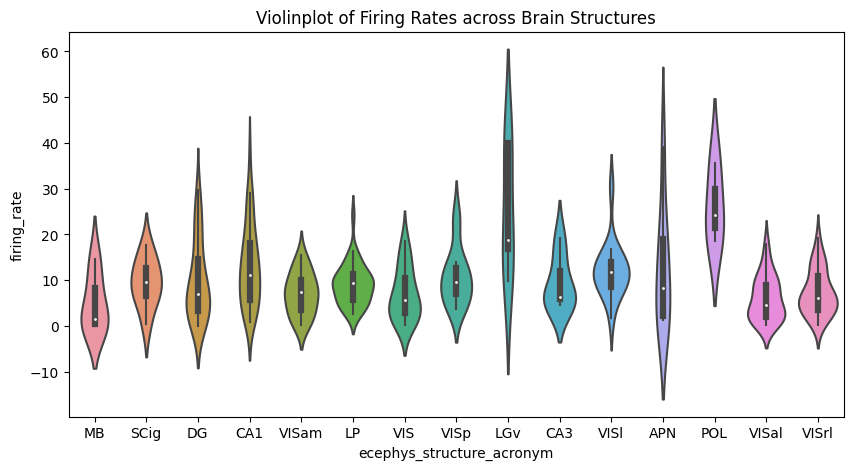

In [3]:
# Return units dataframe with specified snr and isi
col_1 = 'snr'
col_2 = 'isi_violations'
units_df = session.units
good_snr = units_df[units_df[col_1]>2]
good_units_df = good_snr[good_snr[col_2]<0.1]

# Plot our distribution
plt.figure(figsize = (10,5))
sns.violinplot(y='firing_rate', x='ecephys_structure_acronym',data = good_units_df)
plt.title('Violinplot of Firing Rates across Brain Structures')
plt.show()

## Spike Times

Our `EcephysSession` object contains spike times for each unit and they can be accessed via the `spike_times` attribute. This returns a dictionary where the `unit_id` of the neural units are mapped to a list of spike times.  With this data, we are able to compare `spike_times` across units and across stimuli by plotting rasterplots and peristimulus time histograms (PSTHs). 

Because there are many units in a given session, we first need to select a subgroup of units to focus on. For the purposes of this notebook we will work with units that were taken from the primary visual area (`VISp`). Below, we will assign spike times of units from the `VISp` area. 

In [4]:
# Assign the spike times in this particular session session
all_spike_times = session.spike_times

# Assign a list of unit ids for units in VISp brain area
VISp_unit_ids = list(good_units_df[good_units_df['ecephys_structure_acronym'] == 'VISp'].index)

# Assign spike times of first 5 VISp unit entries 
VISp_spike_times = []
for i in range(5):
    VISp_spike_times.append(all_spike_times[VISp_unit_ids[i]])
    print(f"Spikes found for unit {VISp_unit_ids[i]} : {len(all_spike_times[VISp_unit_ids[i]])}")
    print(all_spike_times[VISp_unit_ids[i]])
    print('\n')

Spikes found for unit 950908410 : 215133
[5.51623094e-01 6.20356427e-01 7.80456428e-01 ... 9.81109249e+03
 9.81112212e+03 9.81115902e+03]


Spikes found for unit 950908418 : 39187
[3.54245645e+00 4.25835645e+00 4.95148979e+00 ... 9.80835912e+03
 9.80875156e+03 9.80903712e+03]


Spikes found for unit 950908426 : 66658
[1.85788977e+00 1.86312310e+00 1.94338977e+00 ... 9.81066879e+03
 9.81074882e+03 9.81104352e+03]


Spikes found for unit 950908424 : 108740
[7.26392314e+00 8.98798982e+00 8.99678982e+00 ... 9.81109352e+03
 9.81110979e+03 9.81111379e+03]


Spikes found for unit 950908448 : 120843
[9.58423096e-01 9.90689763e-01 1.86492310e+00 ... 9.81078009e+03
 9.81097156e+03 9.81105216e+03]




With these spike times, we are able to create a raster plot for our unit of interst. Below we will plot out the first 50 seconds of the session. 

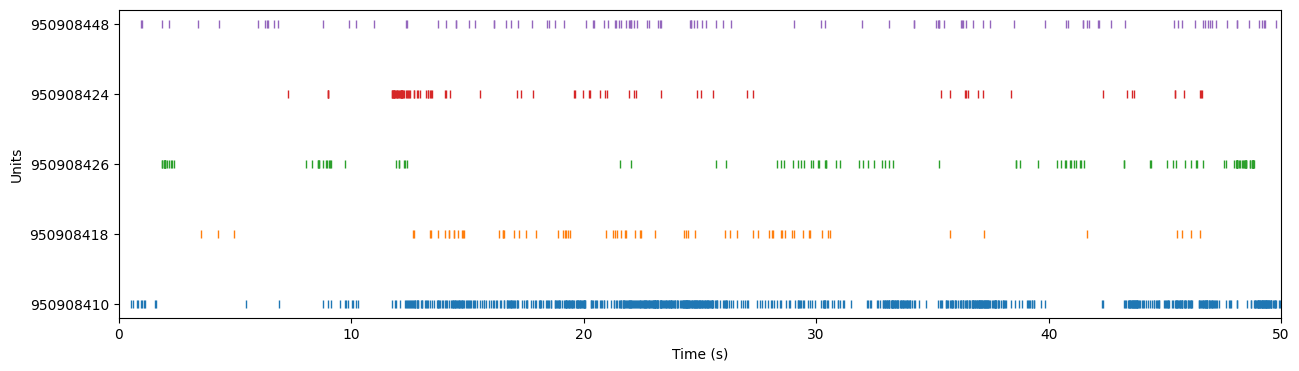

In [5]:
plt.figure(figsize=(15,4))

# Plot a raster plot for units of interest
for i in range(5):
    plt.plot(VISp_spike_times[i], np.repeat(i,len(VISp_spike_times[i])), '|')

plt.xlim(0,50)
plt.yticks(ticks = [0,1,2,3,4], labels = VISp_unit_ids[:5])
plt.xlabel('Time (s)')
plt.ylabel('Units')
plt.show()

A raster plot maybe difficult to see the overall firing activity of a unit becasue there are too many spikes. Instead of looking at each individual spike across time, we can bin our spikes into 1 second bins and plot the spike frequency of each bin using the fucntion below. The funtion takes in a list of spike times for a unit as an argument. The function will also work with a list of lists or `NumPy` array containing multiple units' spike times. 

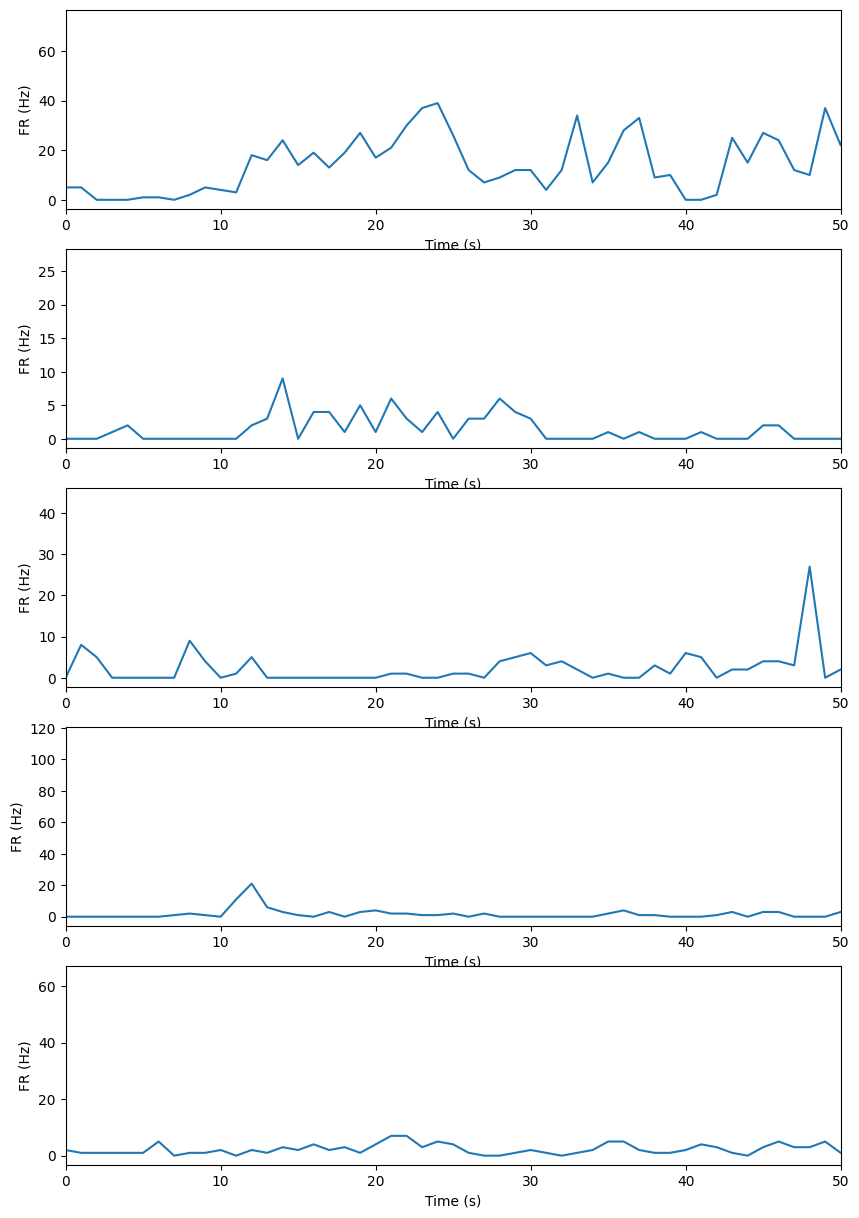

In [6]:
def plot_firing_rates(spike_times, start_time = None , end_time = None):

    # Create Subplot
    fig, ax = plt.subplots(len(spike_times), figsize = (10, 15))
    
    
    # Create PSTH on each sublot
    for i in range(len(spike_times)):

        # Assign total number of bins 
        numbins = int(np.ceil(spike_times[i].max()))
        binned_spikes = np.empty((numbins))

    
        # Assign the frequency of spikes over time
        for j in range(numbins):
            binned_spikes[j] = len(spike_times[i][(spike_times[i]>j)&(spike_times[i]<j+1)])
        
        
        ax[i].plot(binned_spikes)
        ax[i].set_xlabel('Time (s)')
        ax[i].set_ylabel('FR (Hz)')
        
        if (start_time != None) and (end_time != None):
            ax[i].set_xlim(start_time, end_time)
    
    return 

plot_firing_rates(VISp_spike_times, 0, 50)
plt.show()

## Stimulus Presentations

The spike data can be sorted according to the type of stimulus that was presented to the mouse. You can access the different stimuli that were presented in the session by using the attribute `stimulus_names`. 

In [7]:
# Stimuli presented in session
all_stims = session.stimulus_names
all_stims

['spontaneous',
 'gabors',
 'flashes',
 'drifting_gratings',
 'natural_movie_three',
 'natural_movie_one',
 'static_gratings',
 'natural_scenes']

Each stimulus contains a set of parameters that were used when presented to the mouse. For example two gabors stimuli may be presented, but they may have differing temporal frequencies or different x and y positions. Ececuting the `stimulus_presentations` method on our session object will return a pandas dataframe with parameters for each stimulus as the columns which we can use to compare the resoponses of units to different stimulus presentations. 

**Note**: Not all stimuli share the same parameters. If certain parameters do not apply to a stimulus, you will see a `null` value. 

In [8]:
# Stimulus presentation dataframe 
stim_pres = session.stimulus_presentations
stim_pres.head()

,color,contrast,frame,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,x_position,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
0,null,null,null,null,null,null,null,26.219072,null,spontaneous,86.285852,null,null,null,60.066780,0
1,null,0.8,null,45,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,86.285852,0,gabors,86.519369,4,-10,-20,0.233517,1
2,null,0.8,null,45,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,86.519369,0,gabors,86.769565,4,-40,-30,0.250196,2
3,null,0.8,null,90,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,86.769565,0,gabors,87.019762,4,-10,-10,0.250196,3
4,null,0.8,null,0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,87.019762,0,gabors,87.269958,4,20,-10,0.250196,4


Each stimulus used in the session is presented to the mouse in various timeblocks. Using the `get_stimulus_epochs()` method will return a pandas dataframe containing the time periods where a single stimulus type was presented continuously. 

In [9]:
# Continous timeblocks where only 1 type of stimulus was presented
stim_timeblocks = session.get_stimulus_epochs()
stim_timeblocks.head()

,start_time,stop_time,duration,stimulus_name,stimulus_block
0,26.219072,86.285852,60.066780,spontaneous,null
1,86.285852,998.280652,911.994800,gabors,0
2,998.280652,1287.272022,288.991370,spontaneous,null
3,1287.272022,1585.771259,298.499237,flashes,1
4,1585.771259,1587.522722,1.751463,spontaneous,null


The timeblocks above allow us to compare neural activity when a new stimulus is being presented. By using `plt.axvspan` we can divide our current plot to show when one stimulus ends and a new one begins. Plotting this over the firing rates of our units will reveal what `stimulus_name` elicited the highest neural activity. 

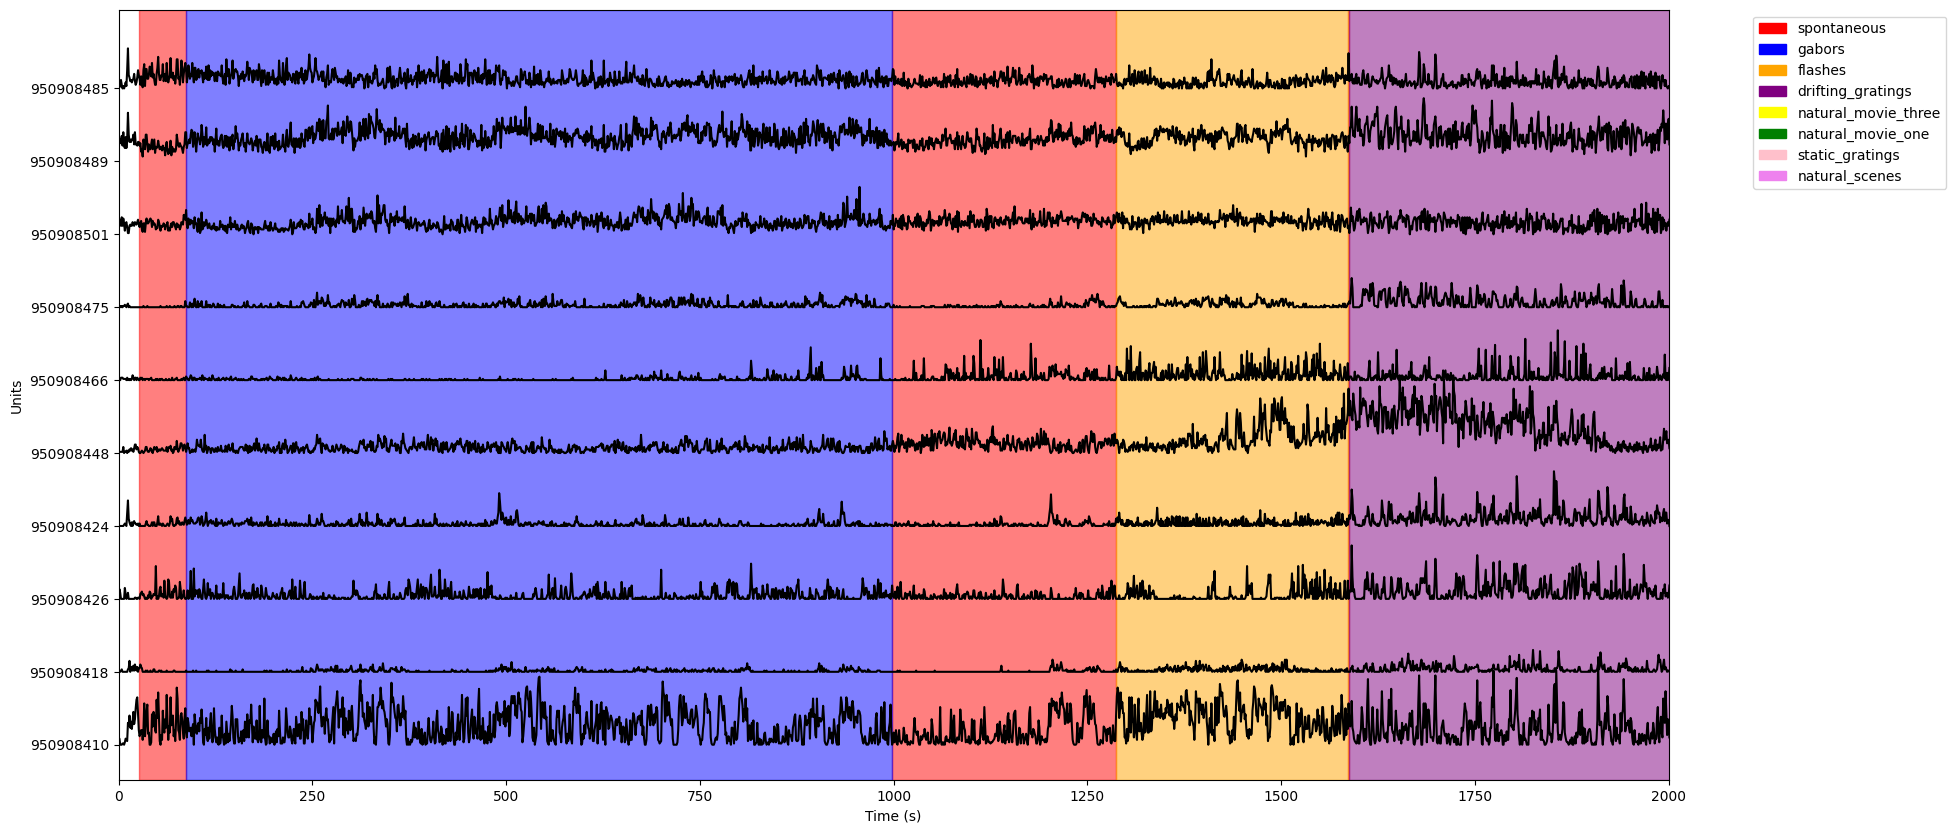

In [10]:
plt.figure(figsize=(20,10))

# Plot first 10 VISp entries spike times in 1 second bins
numunits = 10
numbins = int(np.ceil(VISp_spike_times[0].max()))
visp_binned = np.empty((numunits, numbins))


# Bin each unit's spike times into 1 second bins
for i in range(numunits):
    unit_id = VISp_unit_ids[i]
    spikes = all_spike_times[unit_id]
    for j in range(numbins):
        visp_binned[i,j] = len(spikes[(spikes>j)&(spikes<j+1)])

        
# Plots firing rates, offset each spike train by i
for i in range(numunits):
    plt.plot((i*2)+(visp_binned[i,:]/30.), color='black')

    
# Plots rectangle blocks that indicate new stimulus presentation 
colors = ['red','blue','orange','purple', 'yellow', 'green', 'pink', 'violet']

for c, stim_name in enumerate(all_stims):
    stim = stim_timeblocks[stim_timeblocks['stimulus_name']==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim['start_time'].iloc[j], 
                    xmax=stim['stop_time'].iloc[j],
                    color = colors[c],
                    alpha = 0.5)

        
# Legend showing stimulus timeblocks
colors_leg = []
for i in range(len(colors)):
    temp_color = mpatches.Patch(color = colors[i], label = (all_stims[i]))
    colors_leg.append(temp_color)  

plt.legend(handles = colors_leg, bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.yticks(ticks = np.arange(0,20,2), labels = VISp_unit_ids[:10])
plt.ylabel('Units')
plt.xlabel('Time (s)')
plt.xlim(0,2000)

plt.show()

Alternatively, you could use the `get_stimulus_table()` method to return a subset of stimulus presentation by `stimulus_name`. The returned dataframe will only contain parameters that relate to the given `stimulus_name`. Below we will investigate how our neuronal units responded to a `natural_scenes` stimulus presentations.

In [11]:
col_3 = 'natural_scenes'
natural_scenes_df = session.get_stimulus_table([col_3])
natural_scenes_df.head()

,frame,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,
51353,92,5905.128132,9,natural_scenes,5905.378346,0.250214,4908
51354,114,5905.378346,9,natural_scenes,5905.628560,0.250214,4909
51355,114,5905.628560,9,natural_scenes,5905.878774,0.250214,4909
51356,0,5905.878774,9,natural_scenes,5906.128988,0.250214,4910
51357,37,5906.128988,9,natural_scenes,5906.379197,0.250208,4911


We can look even further and check how the parameters of a stimulus affected the firing rate. In `natural_scenes` presentations, different frames/images were presented to the mouse. Below we will focus on the times that the first `frame` in `natural_scenes_df`, was presented in the session. 

In [12]:
# Assign indices for presentations of our frame of interest
natural_scenes_ids = natural_scenes_df.index

# Assign 'natural_scenes' image id of interest
col_4 = 'frame'
my_image = natural_scenes_df.loc[natural_scenes_ids[1], col_4]

# Return the number of times this image was presented
print('Number of times frame ' + str(my_image)+ ' was presented in the session:')
print(len(natural_scenes_df[natural_scenes_df[col_4]==my_image]))

Number of times frame 114.0 was presented in the session:
50


As you can see from the dataframe above, we also have start and end times for a given stimulus presentation available to us. We can do what we did before and use `plt.axvspan()` to plot the times when the images of interest was presented over the firing rates of our session. 

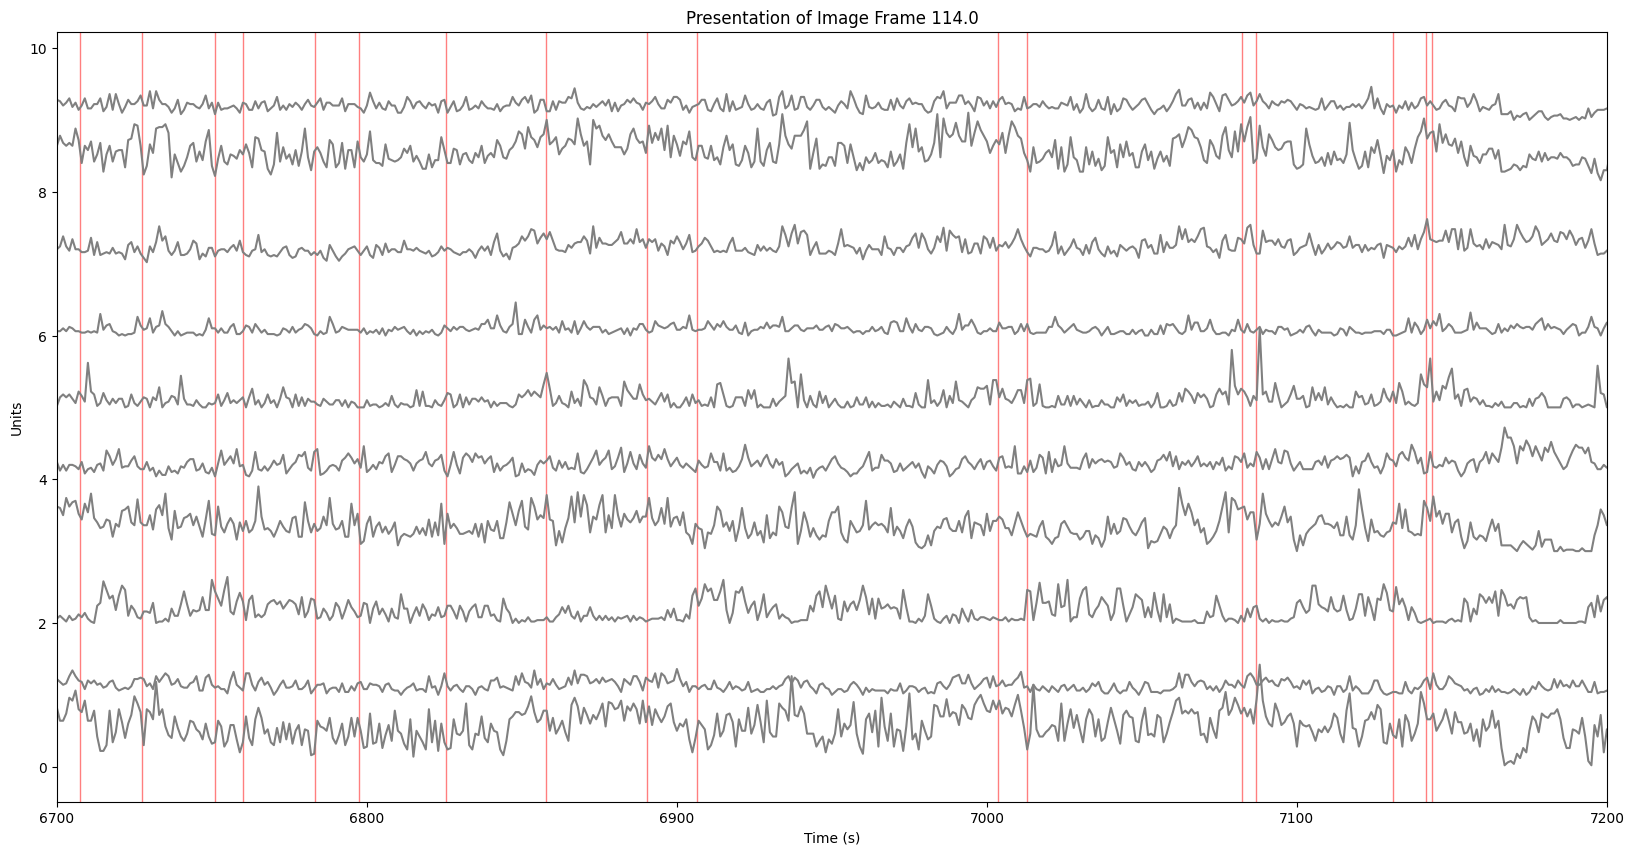

In [13]:
plt.figure(figsize=(20,10))

# Assign a dataframe that only contains presentations of our image of interest
stim_subset = natural_scenes_df[natural_scenes_df[col_4]==my_image]

# Offset the firing rates and plot them
for i in range(numunits):
    plt.plot(i+(visp_binned[i,:]/50), color='gray')

# Plot the times are image of interest was presented
for j in range(len(stim_subset)):
    plt.axvspan(xmin=stim_subset['start_time'].iloc[j], xmax=stim_subset['start_time'].iloc[j], color='r', alpha=0.5)

plt.title('Presentation of Image Frame ' + str(my_image))
plt.xlabel('Time (s)')
plt.ylabel('Units')
plt.xlim(6700,7200)
plt.show()

You are not limited to only plotting the times where a certain image was presented, nor are you limited to only plotting `natural_scenes` stimuli. You can create a similar graph with `gabors`, `flashes`, or any other availabe `stimulus_name`. For example, you can plot all the times when a `gabors` stimulus was presented at a cetain spatial frequncy, temporal frequency, or orientaion. You can use `get_stimulus_parameter_values` to return a dictionary of all parameteres used in a session. 

In [14]:
session_parameters = session.get_stimulus_parameter_values()
for key, value in session_parameters.items():
    print(key + ': ' + str(value))

color: [-1.0 1.0]
contrast: [0.8 1.0]
frame: [-1.0 0.0 1.0 ... 3597.0 3598.0 3599.0]
orientation: [0.0 30.0 45.0 60.0 90.0 120.0 135.0 150.0 180.0 225.0 270.0 315.0]
phase: ['0.0' '0.25' '0.5' '0.75' '[0.0, 0.0]' '[21211.93333333, 21211.93333333]'
 '[3644.93333333, 3644.93333333]']
size: ['[1920.0, 1080.0]' '[20.0, 20.0]' '[250.0, 250.0]' '[300.0, 300.0]']
spatial_frequency: ['0.02' '0.04' '0.08' '0.16' '0.32' '[0.0, 0.0]']
temporal_frequency: [1.0 2.0 4.0 8.0 15.0]
x_position: [-40.0 -30.0 -20.0 -10.0 0.0 10.0 20.0 30.0 40.0]
y_position: [-40.0 -30.0 -20.0 -10.0 0.0 10.0 20.0 30.0 40.0]


Below we will focus on the `gabors` presentations in our session and see how different orientations affected the firing rate. We will take a look at the first `gabors` presentation that was oriented 90 degrees. 

In [15]:
# Assign dataframe with only 'gabors' presentations
col_5 = 'gabors'
gabors_df = session.get_stimulus_table(col_5)

# Subselect units that were presented 90 degree orientation stimuli
col_6 = 'orientation'
subset = gabors_df[(gabors_df[col_6]==90)]

#  Assign start and end time of first 'gabors' presentation
start = subset['start_time'].iloc[0]
end = subset['stop_time'].iloc[0]

Below we will plot a raster plot containing the neural activity of all the neurons in response to the first gabors presentation. 

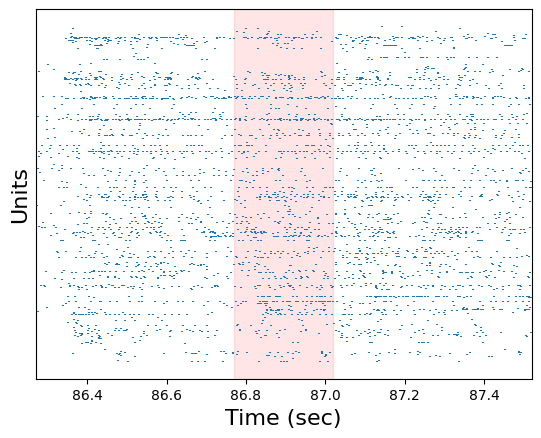

In [16]:
# Assign number of units you will plot
num_units = len(all_spike_times)
ystep = 1 / num_units
    
# Set axis limits to include all units of interest
ymin = 0
ymax = ystep

# Plot raster for spikes within the start and end times of the stimulus presentation
for unit_id, unit_spike_times in all_spike_times.items():
    unit_spike_times = unit_spike_times[np.logical_and(unit_spike_times >= start -0.5, unit_spike_times < end+0.5)]
    plt.vlines(unit_spike_times, ymin=ymin, ymax=ymax)

    ymin += ystep
    ymax += ystep

plt.xlim([start - 0.5, end+0.5])
plt.axvspan(start, end, color='red', alpha=0.1)
plt.xlabel('Time (sec)', fontsize=16)
plt.ylabel('Units', fontsize=16)
plt.tick_params(axis="y", labelleft=False, left=False)
plt.show()

Peri stimulus time histograms and raster plots can also be created with classes and functions from the `spykes` module. With this, we are able to plot the firing activity of single neurons or of neuron populations. The `NeuroVis()` class is used to visualize single neuron activity. It takes in an array of spike times as an arguement as well as the `name` of the neuron. We can then use the fucntion `get_raster()` to compute and plot a raster plot across all stimulus presentations. 

Please visit the<a href = 'http://kordinglab.com/spykes/api/plot.html'> spykes plotting section</a> of the spykes documentation for additional help on the classes and functions used below. 

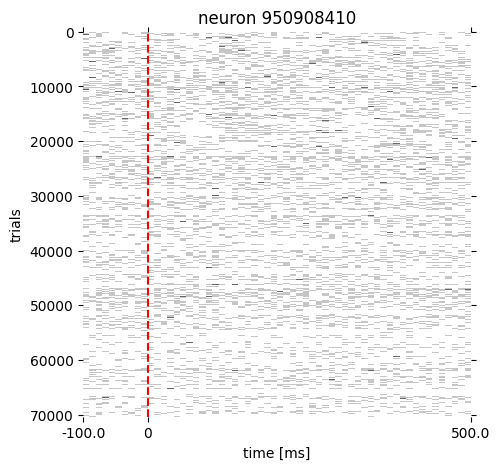

In [17]:
nvs = NeuroVis(VISp_spike_times[0], name = '950908410')

fig = plt.figure(figsize=(5, 5))

nvs.get_raster(event='start_time', df=stim_pres)
plt.show()

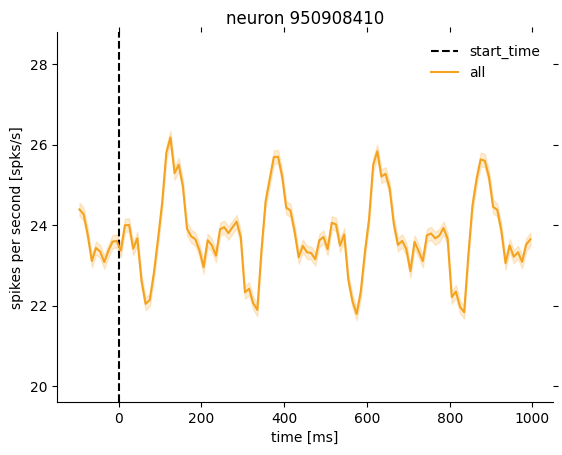

In [18]:
nvs.get_psth(event='start_time', df=stim_pres, binsize = 10, window = [-100, 1000])
plt.show()

## Running Speed

The running speed of the mice in our session have also been recorded and are available to you. You can access the running speed by calling `running_speed` on our `EcephysSession` object. This will return a dataframe that contains the `start_time`, `end_time`, and `velocity` of our session.

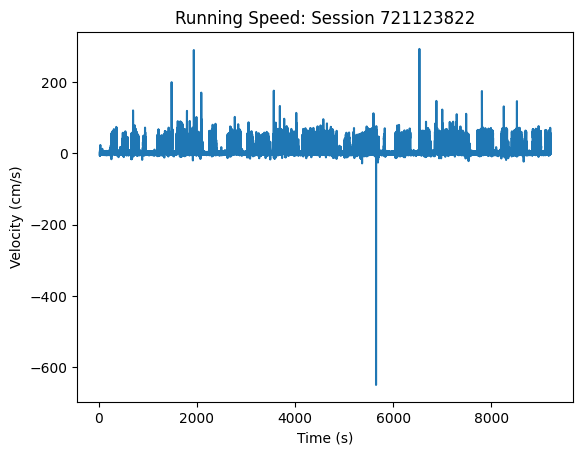

In [19]:
running_speed = session.running_speed

plt.plot(running_speed['end_time'], running_speed['velocity'])
plt.title('Running Speed: Session 721123822')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (cm/s)')
plt.show()

With the running speed, we can ask if their is correlation between the firing rates of our units and the velocity of our mouse. Similar to how we plotted above, we can plot the running speed of the session over the firing rates and see if increases in running speed align with increases in neural activity. 

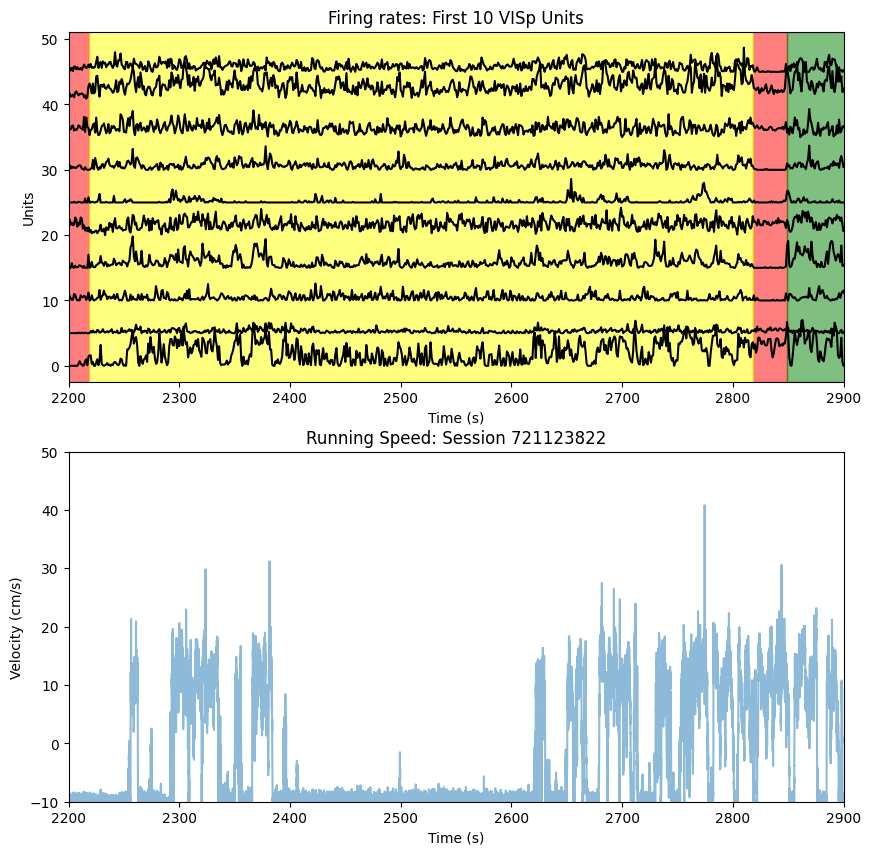

In [20]:
fig, ax = plt.subplots(2, figsize = (10,10) )

# Plot firing rates
for i in range(numunits):
    ax[0].plot((i*5)+(visp_binned[i,:]/10), color='black')

# Plot the running speed underneath     
ax[1].plot(running_speed['end_time'], (running_speed['velocity']*0.5)-10, alpha = 0.5)

# Add color bars for timeblocks
# Remove colorblocks 
for c, stim_name in enumerate(all_stims):
    stim = stim_timeblocks[stim_timeblocks['stimulus_name']==stim_name]
    for j in range(len(stim)):
        ax[0].axvspan(xmin=stim['start_time'].iloc[j], 
                    xmax=stim['stop_time'].iloc[j], 
                    color=colors[c], 
                    alpha=0.5)


ax[0].set_title('Firing rates: First 10 VISp Units')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Units')
ax[0].set_xlim(2200,2900)

ax[1].set_title('Running Speed: Session 721123822')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Velocity (cm/s)')
ax[1].set_xlim(2200,2900)

plt.ylim(-10,50)
plt.show()

## Signal Correlations